NOTE: for the most up to date version of this notebook, please copy from

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1ntAL_zI68xfvZ4uCSAF6XT27g0U4mZbW#scrollTo=VHS_o3KGIyXm)




## **Training YOLOv3 object detection on a custom dataset**



### **Overview**

This notebook walks through how to train a YOLOv3 object detection model on your own dataset using Roboflow and Colab.

In this specific example, we'll training an object detection model to recognize chess pieces in images. **To adapt this example to your own dataset, you only need to change one line of code in this notebook.**

![Chess Example](https://i.imgur.com/nkjobw1.png)

### **Our Data**

Our dataset of 289 chess images (and 2894 annotations!) is hosted publicly on Roboflow [here](https://public.roboflow.ai/object-detection/chess-full).

### **Our Model**

We'll be training a YOLOv3 (You Only Look Once) model. This specific model is a one-shot learner, meaning each image only passes through the network once to make a prediction, which allows the architecture to be very performant, viewing up to 60 frames per second in predicting against video feeds.

The GitHub repo containing the majority of the code we'll use is available [here](https://github.com/roboflow-ai/yolov3).

### **Training**

Google Colab provides free GPU resources. Click "Runtime" → "Change runtime type" → Hardware Accelerator dropdown to "GPU."

Colab does have memory limitations, and notebooks must be open in your browser to run. Sessions automatically clear themselves after 12 hours.

### **Inference**

We'll leverage the `detect.py --weights weights/last.pt` script to produce predictions. Arguments are specified below.










In [1]:
import os
import torch
from IPython.display import Image, clear_output 
print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.6.0+cu101 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15079MB, multi_processor_count=40)


In [2]:
!git clone https://github.com/roboflow-ai/yolov3  # clone

Cloning into 'yolov3'...
remote: Enumerating objects: 8443, done.
remote: Total 8443 (delta 0), reused 0 (delta 0), pack-reused 8443
Receiving objects: 100% (8443/8443), 6.89 MiB | 27.04 MiB/s, done.
Resolving deltas: 100% (5825/5825), done.


In [3]:
%ls

sample_data/  yolov3/


## Get Data from Roboflow

Create an export from Roboflow. **Select "YOLO Darknet" as the export type.**

Our labels will be formatted to our model's architecture.

In [4]:
# REPLACE THIS LINK WITH YOUR OWN
!curl -L "https://public.roboflow.ai/ds/3103AzYDyI?key=0MAoJ714iA" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    71  100    71    0     0    158      0 --:--:-- --:--:-- --:--:--   158
100   890  100   890    0     0    762      0  0:00:01  0:00:01 --:--:--   762
100 7263k  100 7263k    0     0  4539k      0  0:00:01  0:00:01 --:--:-- 50.0M
Archive:  roboflow.zip
 extracting: train/b0f3d66c8be13f5f6aa25b67a06bdcfa_jpg.rf.01b3f3243bf31cb2ea18a89fd58044be.jpg  
 extracting: test/e0d38d159ad3a801d0304d7e275812cc_jpg.rf.0cd06a940ccc9894109d83792535e3eb.jpg  
 extracting: train/f3a5df526393445c6e2d38f66c1f5c27_jpg.rf.09aeba93cdea53cc6a6db62f6056ec35.jpg  
 extracting: train/0f4512d71c096f2699d705792e88fc58_jpg.rf.0971fe35ffe3ebbcc3e2a709de978aec.jpg  
 extracting: train/e79deba8fe520409790b601ad61da4ee_jpg.rf.016bc04dee292f80d1f975931f32bc21.jpg  
 extracting: train/dd6b5c3cb2d7e77f38f1dfeb2bff0431_jpg.rf.065f8833508d101a1f1449e8fbabc314.j

## Organize data and labels for Ultralytics YOLOv3 Implementation

Ultalytics's implemention of YOLOv3 calls for [a specific file management](https://github.com/ultralytics/yolov3/wiki/Train-Custom-Data) where our images are in a folder called `images` and corresponding labels in a folder called `labels`. The image and label names must match identically. Fortunately, our files are named appropriately from Roboflow.

We need to reorganize the folder structure slightly.

In [5]:
%cd train

/content/train


In [6]:
%ls

00bc0cacffdebe6b11bdeec56f63ee49_jpg.rf.59f0f02a28f020d480fd5d1d8aa32f6d.jpg
00bc0cacffdebe6b11bdeec56f63ee49_jpg.rf.59f0f02a28f020d480fd5d1d8aa32f6d.txt
0115e4df73475b550e5c6f7a88b2474f_jpg.rf.dfa577bd4af5440d689046c2f48bc48e.jpg
0115e4df73475b550e5c6f7a88b2474f_jpg.rf.dfa577bd4af5440d689046c2f48bc48e.txt
02f0931b536dfba10affc3231a3d64fb_jpg.rf.7daf233a70122377355a36ca33e82aa4.jpg
02f0931b536dfba10affc3231a3d64fb_jpg.rf.7daf233a70122377355a36ca33e82aa4.txt
0301b7f9ed4d5ba503fda79fc4370c29_jpg.rf.3ecfd27607406c9f46c1525efd39e17b.jpg
0301b7f9ed4d5ba503fda79fc4370c29_jpg.rf.3ecfd27607406c9f46c1525efd39e17b.txt
03886821377011fec599e8fa12d86e89_jpg.rf.78d439f975872bc0120d597bd265684b.jpg
03886821377011fec599e8fa12d86e89_jpg.rf.78d439f975872bc0120d597bd265684b.txt
03d3ff4582c8125d69c19a72f846bec8_jpg.rf.5f77781cbc56eff8679f258ff4f7cc9f.jpg
03d3ff4582c8125d69c19a72f846bec8_jpg.rf.5f77781cbc56eff8679f258ff4f7cc9f.txt
040f2bcba5afce3afafdd5bbf36d2ca5_jpg.rf.fe6d0720247b60f2c6e1cda98fd00cab.jpg

In [10]:
%mkdir labels
%mkdir images

mkdir: cannot create directory ‘labels’: File exists
mkdir: cannot create directory ‘images’: File exists


In [11]:
%mv *.jpg ./images/
%mv *.txt ./labels/

mv: cannot stat '*.jpg': No such file or directory
mv: cannot stat '*.txt': No such file or directory


In [12]:
%cd images

/content/train/images


In [ ]:
# create Ultralytics specific text file of training images
file = open("train_images_roboflow.txt", "w") 
for root, dirs, files in os.walk("."):
    for filename in files:
      # print("../train/images/" + filename)
      if filename == "train_images_roboflow.txt":
        pass
      else:
        file.write("../train/images/" + filename + "\n")
file.close()

In [ ]:
%cat train_images_roboflow.txt

../train/images/7ee8d13861bdc45e40a7cfe190a8d8a6_jpg.rf.f89633224312e1c80ce73c4e05c65051.jpg
../train/images/fa3cf2724c1648a8822b59ac0759475f_jpg.rf.3ad41d095557e6bfb446af5de5553e75.jpg
../train/images/285d7c487a4e20ad832a74acb527b77f_jpg.rf.5ce3eb6a89b4c0019fde9d22a5921104.jpg
../train/images/4de23afff63bc169b4ebe547a9c9b692_jpg.rf.0cf789652d85886de3d00b05bef061eb.jpg
../train/images/389b4c47568c78c44df11dbb1377ffea_jpg.rf.1d6174519a8e98c853c57584e8cba891.jpg
../train/images/f3302c754c6fd42130014199ee327d10_jpg.rf.56672ccf94cd354a96888ca0e8a8e4e0.jpg
../train/images/c7890b749d14d3488066cbdfac4620fd_jpg.rf.3850673b2781e44e1a293fe12a9cde12.jpg
../train/images/8dd12470c30e3b265e8933a6fee7ad28_jpg.rf.84b8584b870b790d4f5d40bdd24c1af4.jpg
../train/images/49f78dc9aaeadd0c76ed2def75c358f3_jpg.rf.ebe11640761df4735fa11bf2516c7967.jpg
../train/images/d29148a2233950a7777285281cbfccff_jpg.rf.2e63366f947507e0735a25d532caaa54.jpg
../train/images/1a8a4abcba7c4ead35c01f05b9fae8e5_jpg.rf.e36b61dd77198f

In [ ]:
%cd ../../valid

/content/valid


In [ ]:
%mkdir labels
%mkdir images

In [ ]:
%mv *.jpg ./images/
%mv *.txt ./labels/

In [ ]:
%cd images

/content/valid/images


In [ ]:
# create Ultralytics specific text file of validation images
file = open("valid_images_roboflow.txt", "w") 
for root, dirs, files in os.walk("."):
    for filename in files:
      # print("../train/images/" + filename)
      if filename == "valid_images_roboflow.txt":
        pass
      else:
        file.write("../valid/images/" + filename + "\n")
file.close()

In [ ]:
%cat valid_images_roboflow.txt

../valid/images/d4f7caf01359b9a757c930140f746fad_jpg.rf.ccdaecd58d74f3bc49babbde826e2e60.jpg
../valid/images/495019998442ddf85b59e387d4916cd3_jpg.rf.ba08d9a498ecad855a31f6c64f7ffa96.jpg
../valid/images/3312e3bb60e338e9c1a614f0f8960dd8_jpg.rf.cc13ce4af944d2aeb4afaa7959fd72fd.jpg
../valid/images/eca42980852e6c5db10ee84aac23f9c6_jpg.rf.746317745a1bb86f4da60bfd8eb2db36.jpg
../valid/images/5d492613cf4021eb387513e2635cb3aa_jpg.rf.8ea3718b5ca86bbaeadf248887f74fdf.jpg
../valid/images/26fa37995fa5b18ec40e0a94e6d91104_jpg.rf.ae716df13c86ffbaf972aed9fa4e08ef.jpg
../valid/images/d6e283a49b0395a6d5867c9e98e32045_jpg.rf.98019c4213f1dfdb5e6ad1650216f5b6.jpg
../valid/images/793c79d55c8a252b7a954d074b1d6498_jpg.rf.3af5b0c88f75574c8733ad6a9a511285.jpg
../valid/images/0d9afc3d23392c3958f53d7fe71fd2f1_jpg.rf.907162426130ed7370ad72200fdd3bc0.jpg
../valid/images/0af4c8f0fb5d899e9d1c8d34b2efa980_jpg.rf.57b0654146d453d6cae13cdddc229aa2.jpg
../valid/images/57d1d1fb35ed875f9e770660bb03b6d7_jpg.rf.ee46450ad0ef6a

## Set up model config

We should configure our model for training.

This requires editing the `roboflow.data` file, which tells our model where to find our data, our numbers of classes, and our class label names.

Our paths for our labels and images are correct.

But we need to update our class names. That's handled below..




In [ ]:
%cd ../../yolov3/data

/content/yolov3/data


In [ ]:
# display class labels imported from Roboflow
%cat ../../train/_darknet.labels

black-bishop
black-king
black-knight
black-pawn
black-queen
black-rook
white-bishop
white-king
white-knight
white-pawn
white-queen
white-rook

In [ ]:
# convert .labels to .names for Ultralytics specification
%cat ../../train/_darknet.labels > ../../train/roboflow_data.names

In [ ]:
def get_num_classes(labels_file_path):
    classes = 0
    with open(labels_file_path, 'r') as f:
      for line in f:
        classes += 1
    return classes

In [ ]:
# update the roboflow.data file with correct number of classes
import re

num_classes = get_num_classes("../../train/_darknet.labels")
with open("roboflow.data") as f:
    s = f.read()
with open("roboflow.data", 'w') as f:
    
    # Set number of classes num_classes.
    s = re.sub('classes=[0-9]+',
               'classes={}'.format(num_classes), s)
    f.write(s)

In [ ]:
# display updated number of classes
%cat roboflow.data

classes=12
train=../train/images/train_images_roboflow.txt
valid=../valid/images/valid_images_roboflow.txt
names=../train/roboflow_data.names


## Training our model

Once we have our data prepped, we'll train our model using the train script.

By default, this script trains for 300 epochs.

In [ ]:
%cd ../

/content/yolov3


In [ ]:
!python3 train.py --data data/roboflow.data --epochs 300

Namespace(accumulate=4, adam=False, batch_size=16, bucket='', cache_images=False, cfg='cfg/yolov3-spp.cfg', data='data/roboflow.data', device='', epochs=300, evolve=False, img_size=[416], multi_scale=False, name='', nosave=False, notest=False, rect=False, resume=False, single_cls=False, var=None, weights='weights/yolov3-spp-ultralytics.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla K80', total_memory=11441MB)

2020-07-26 16:19:30.790218: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Model Summary: 225 layers, 6.29987e+07 parameters, 6.29987e+07 gradients
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   1961      0 --:--:-- --:--:-- --:--:--  1961
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0  

## Display training performance

We'll use a default provided script to display image results. **For example:**

![example results](https://user-images.githubusercontent.com/26833433/63258271-fe9d5300-c27b-11e9-9a15-95038daf4438.png)

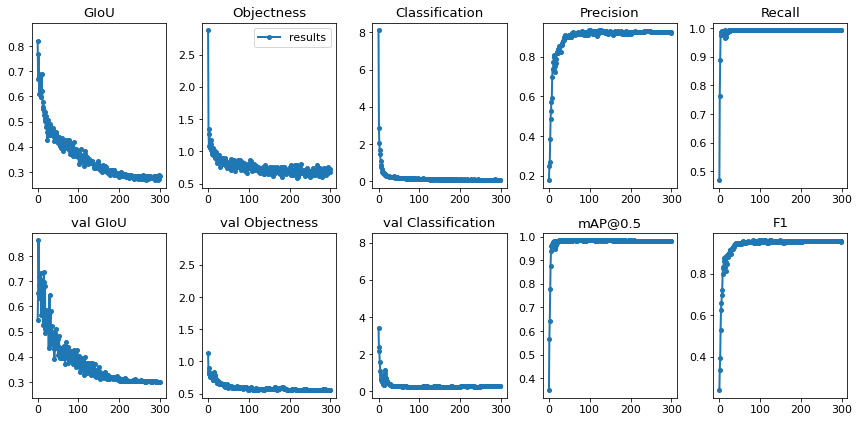

In [ ]:
from utils import utils; utils.plot_results()

## Conduct inference and display results



### Conduct inference

The below script has a few key arguments we're using:
- **Weights**: we're specifying the weights to use for our model should be those that we most recently used in training
- **Source**: we're specifying the source images we want to use for our predictions
- **Names**: we're defining the names we want to use. Here, we're referencing `roboflow_data.names`, which we created from our Roboflow `_darknet.labels`italicized text above.

In [ ]:
!python3 detect.py --weights weights/last.pt --source='/content/gdrive/My Drive/chess_practice_yolo/chess_yolo_v3_pytorch/dataset/train/0115e4df73475b550e5c6f7a88b2474f_jpg.rf.dfa577bd4af5440d689046c2f48bc48e.jpg' --names=../train/roboflow_data.names

Namespace(agnostic_nms=False, cfg='cfg/yolov3-spp.cfg', classes=None, conf_thres=0.3, device='', fourcc='mp4v', half=False, img_size=416, iou_thres=0.6, names='../train/roboflow_data.names', output='output', save_txt=False, source='../test', view_img=False, weights='weights/last.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla K80', total_memory=11441MB)

Model Summary: 225 layers, 6.29987e+07 parameters, 6.29987e+07 gradients
image 1/29 ../test/0b47311f426ff926578c9d738d683e76_jpg.rf.58093f799a6f56c30830617ca44745ca.jpg: 416x416 1 white-bishops, Done. (0.099s)
image 2/29 ../test/1c0060ef868bdc326ce5e6389cb6732f_jpg.rf.a07af6147d4a79376c182d2d95c639ec.jpg: 416x416 1 white-rooks, Done. (0.091s)
image 3/29 ../test/2f6fb003bb89cd401322a535acb42f65_jpg.rf.49b342a7b1f6de3f0e328beaf094a945.jpg: 416x416 2 black-bishops, 1 black-kings, 2 black-knights, 8 black-pawns, 1 black-queens, 2 black-rooks, 2 white-bishops, 1 white-kings, 2 white-knights, 8 white-pawns, 1 white-queens, 2 white-

### Displaying our results

Ultralytics generates predictions which include the labels and bounding boxes "printed" directly on top of our images. They're saved in our `output` directory within the YOLOv3 repo we cloned above.

In [ ]:
# import libraries for display
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Image
from glob import glob
import random
import PIL

2f6fb003bb89cd401322a535acb42f65_jpg.rf.49b342a7b1f6de3f0e328beaf094a945.jpg


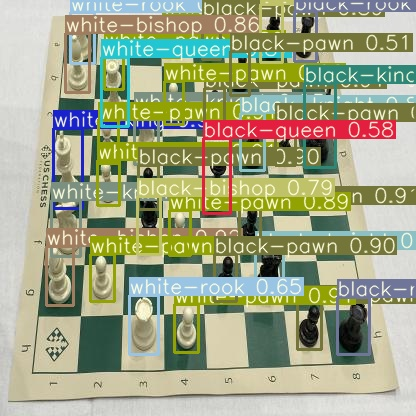

In [ ]:
# plot just one random image prediction
filename = random.choice(os.listdir('./output'))
print(filename)
Image('./output/' + filename)

In [ ]:
# grab all images from our output directory
images = [ PIL.Image.open(f) for f in glob('./output/*') ]

In [ ]:
# convert images to numPy
def img2array(im):
    if im.mode != 'RGB':
        im = im.convert(mode='RGB')
    return np.fromstring(im.tobytes(), dtype='uint8').reshape((im.size[1], im.size[0], 3))

In [ ]:
# create array of numPy images
np_images = [ img2array(im) for im in images ]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  """


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


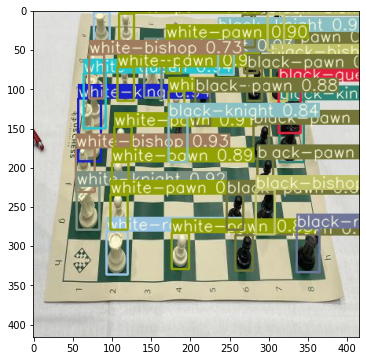

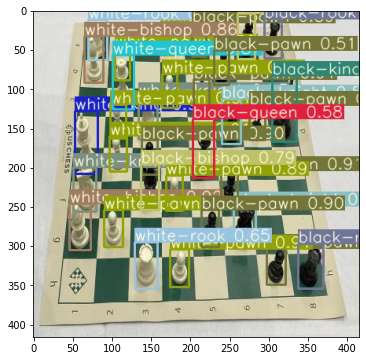

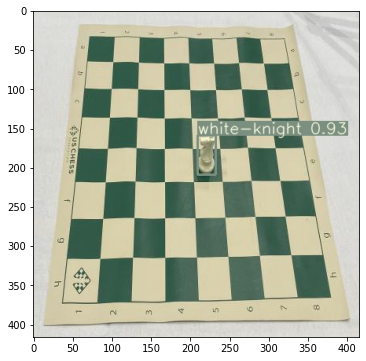

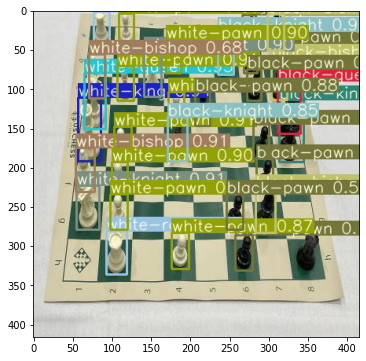

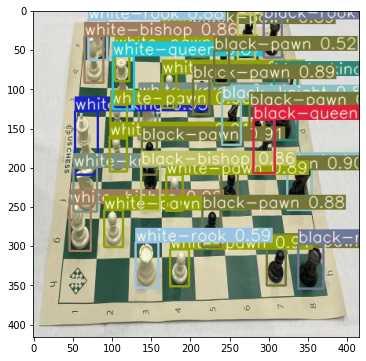

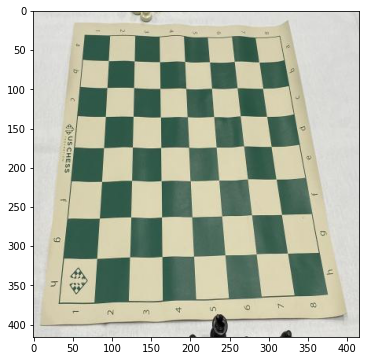

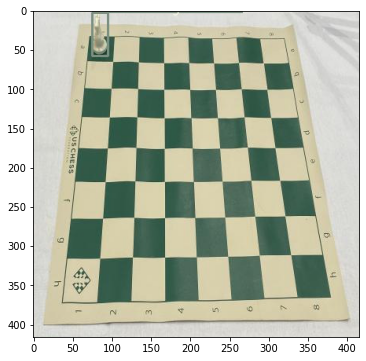

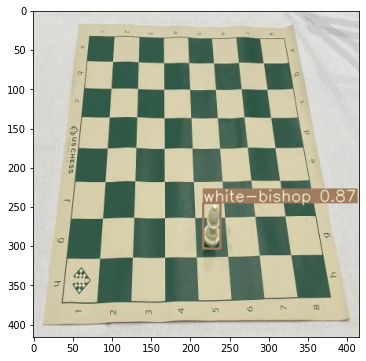

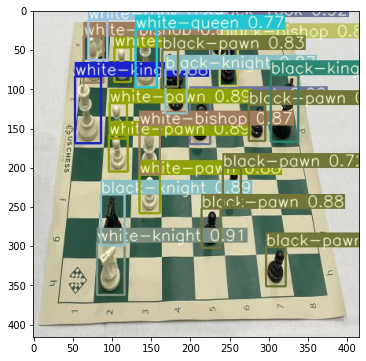

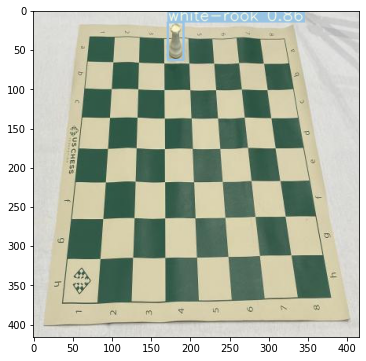

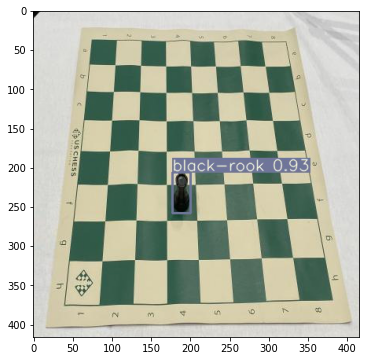

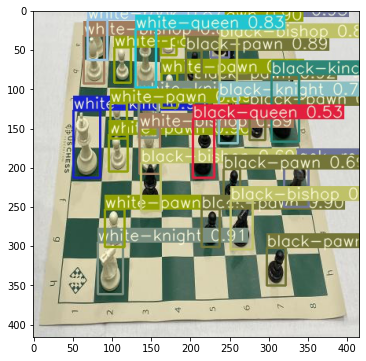

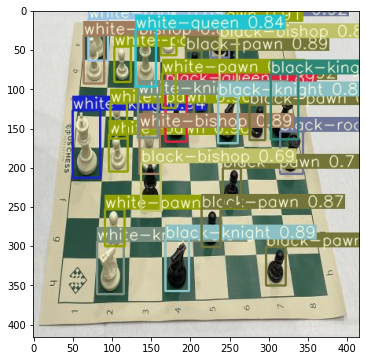

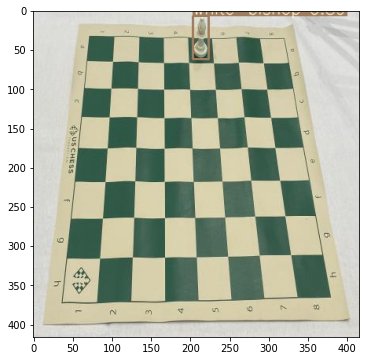

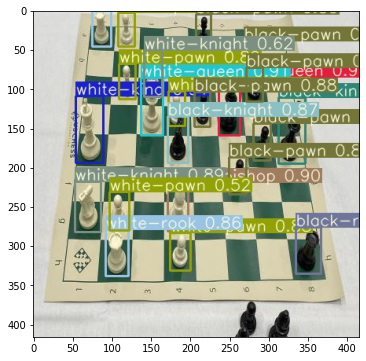

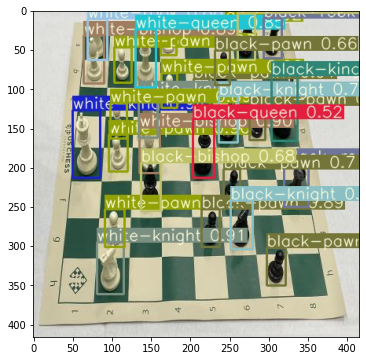

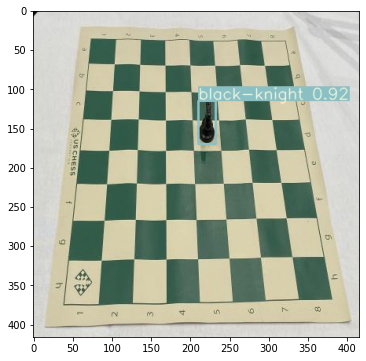

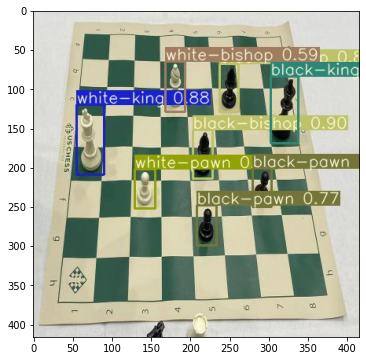

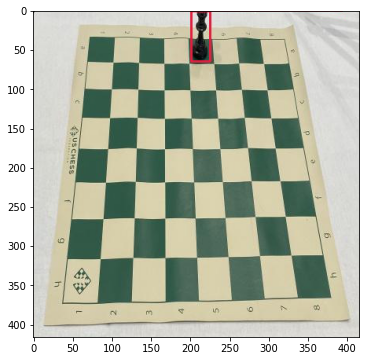

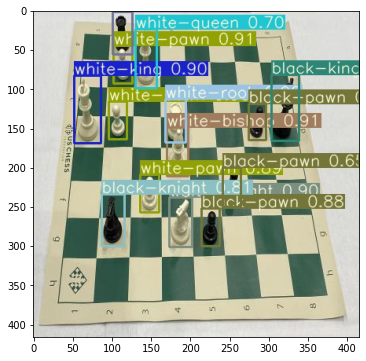

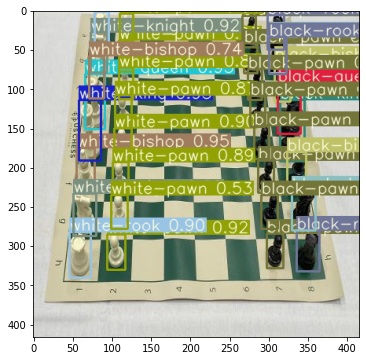

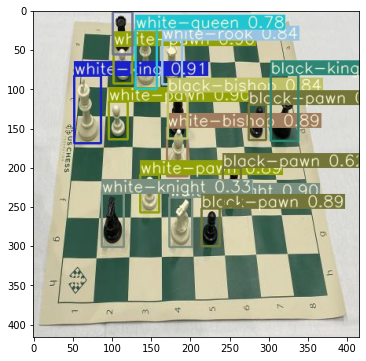

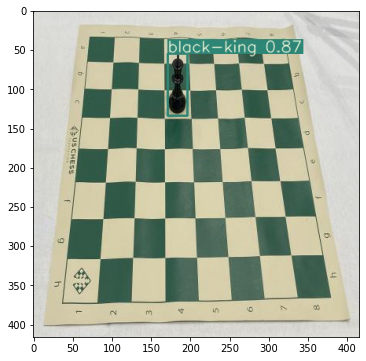

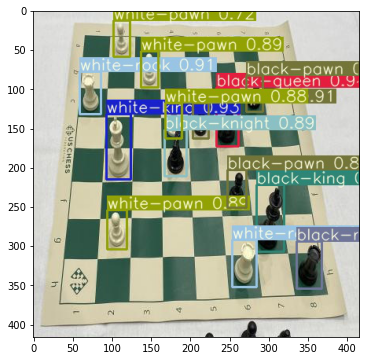

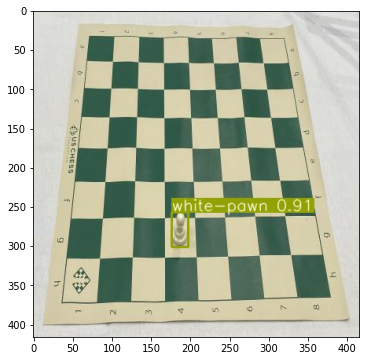

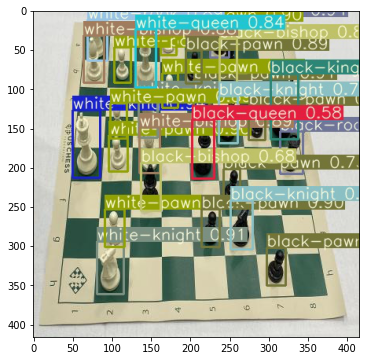

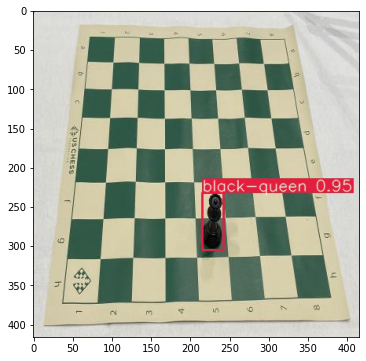

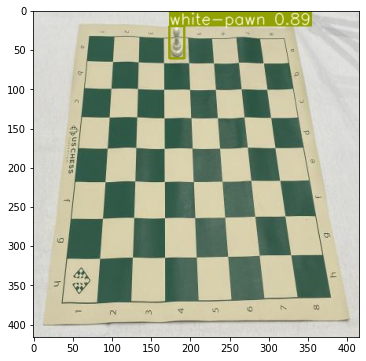

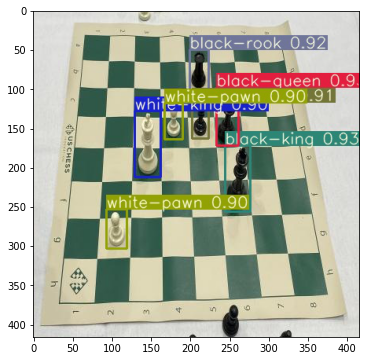

In [ ]:
# plot ALL results in test directory (NOTE: adjust figsize as you please)
for img in np_images:
    plt.figure(figsize=(8, 6))
    plt.imshow(img)

## Save Our Weights

We can save the weights of our model to use them for inference in the future, or pick up training where we left off. 

We can first save them locally. We'll connect our Google Drive, and save them there.


In [ ]:
# save locally
from google.colab import files
files.download('./weights/last.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# connect Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
%pwd

'/content/yolov3'

In [ ]:
# create a copy of the weights file with a datetime 
# and move that file to your own Drive
%cp ./weights/last.pt ./weights/last_copy.pt
%mv ./weights/last_copy.pt  /content/gdrive/My\ Drive/chess_practice_yolo/